In [1]:
import stlearn as st
import scanpy as sc
import pandas as pd
import re
import numpy as np

from collections import Counter
from scipy.sparse import csr_matrix
import anndata as ad
import seaborn as sns
#import harmonypy as hm
from matplotlib import pyplot as plt
from stlearn.spatials.clustering import localization
from scipy.stats import spearmanr

import gseapy as gp
from matplotlib.colors import LogNorm


plt.rcParams['figure.figsize'] = [6, 6]

# Helping functions 

In [2]:
# Function to remove outliers
def remove_outliers_function(df, outliers_percentage = 0.02):
    # Calculate the lower and upper percentile for each column
    lower_percentile = df.quantile(outliers_percentage/2)
    upper_percentile = df.quantile(1- outliers_percentage/2)
    
    # Filter the DataFrame to keep only the rows within the percentiles
    df_filtered = df.apply(lambda x: x[(x >= lower_percentile[x.name]) & (x <= upper_percentile[x.name])])
    
    # Drop rows with any NaN values (which were outliers)
    df_filtered = df_filtered.dropna()
    
    return df_filtered

def preprocess(adata, louvain_resolution, n_top_genes = 2000, n_comps = 50, diffmap = True, remove_outliers = True, scale = True, outliers_percentage = 0.02):
    """
    Preprocess the data. Be carefull about the order in which diffmap is called relative to other functions
    """

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    # Keep raw data
    adata.raw = adata
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

    if scale == True:
        sc.pp.scale(adata)

    
    sc.pp.pca(adata, n_comps = n_comps, random_state=0)

    if remove_outliers == True:
        PCs = pd.DataFrame(adata.obsm['X_pca'])
        PCs.index = adata.obs_names
        non_outliers = remove_outliers_function(PCs, outliers_percentage = outliers_percentage).index
        adata = adata[non_outliers]    
        sc.pp.pca(adata, n_comps = n_comps, random_state=0)

    sc.pp.neighbors(adata, use_rep="X_pca", random_state=0)

    if diffmap == True:
        sc.tl.diffmap(adata, n_comps = n_comps, random_state=0)
        sc.pp.neighbors(adata, use_rep="X_diffmap", random_state=0)
        
    st.tl.clustering.louvain(adata,random_state=0, resolution = louvain_resolution)

    return adata

def filter_cells(adata, obs_name, threshold):
    """
    Rename the clusters to fix their bug that the clusters need to be called 0,1,2,3,...
    """
    counts = adata.obs[obs_name].value_counts()
    filtered_categories = counts[counts >= threshold].index
    adata = adata[adata.obs[obs_name].isin(filtered_categories)]

    return(adata)

def get_rank_cor_drug(adata, screening_genes=None):
    
    tmp = adata.uns['drug2cell'].copy()
    tmp = tmp.to_df()
    tmp.columns = list(adata.uns['drug2cell'].var.index)

    if screening_genes != None:
        tmp = tmp[screening_genes]
    dpt = adata.obs["dpt_pseudotime"].values
    drugs = []
    score = []
    pvalue = []
    for drug in list(adata.uns['drug2cell'].var.index):
        drugs.append(drug)
        score.append(spearmanr(tmp[drug].values, dpt)[0])
        pvalue.append(spearmanr(tmp[drug].values, dpt)[1])
    import pandas as pd

    final = pd.DataFrame({"drug": drugs, "score": score, "p-value": pvalue})
    return final

def get_rank_cor_drug_pseudotime(adata, screening_genes=None):
    
    tmp = tmp = adata.to_df()

    if screening_genes != None:
        tmp = tmp[screening_genes]
    
    dpt = adata.obs["dpt_pseudotime"].values
    genes = []
    score = []
    pvalue = []
    for gene in list(adata.var.index):
        genes.append(gene)
        score.append(spearmanr(tmp[gene].values, dpt)[0])
        pvalue.append(spearmanr(tmp[gene].values, dpt)[1])
    import pandas as pd

    final = pd.DataFrame({"gene": genes, "score": score, "p-value": pvalue})
    return final


def detect_pseudotime_markers_total(
    adata,
    use_label,
    cutoff_spearman=0.4,
    cutoff_pvalue=0.05,
    screening_genes=None,
    use_raw_count=False,
    GenesOrDrugs = "genes"
):
    """\
    Detect the genes driving pseudotime

    Parameters
    ----------
    adata
        Annotated data matrix.
    cutoff_spearman
        The threshold of correlation coefficient.
    cutoff_pvalue
        The threshold of p-value.
    screening_genes
        List of customised genes.
    use_raw_count
        True if user wants to use raw layer data.
    Returns
    -------
    Anndata
    """
    print(
        "Detecting the pseudotime markers"
    )
    query_adata = adata[adata.obs[use_label].notna(), :]

    if(GenesOrDrugs == 'drugs'):
        spearman_result = get_rank_cor_drug(
            query_adata, screening_genes=screening_genes
        )
        spearman_result = spearman_result[spearman_result["p-value"] < cutoff_pvalue]
        positive = spearman_result[spearman_result["score"] >= cutoff_spearman].sort_values(
            "score", ascending=False
        )
        negative = spearman_result[
            spearman_result["score"] <= cutoff_spearman * (-1)
        ].sort_values("score")
    
        result = pd.concat([positive, negative])
    
        adata.uns["corr_pseudotime_drugs"] = result
    
        print(
            "Transition drugs markers result is stored in adata.uns[corr_pseudotime]"
        )
    else:
        spearman_result = get_rank_cor_drug_pseudotime(
            query_adata, screening_genes=screening_genes
        )

        spearman_result = spearman_result[spearman_result["p-value"] < cutoff_pvalue]
        positive = spearman_result[spearman_result["score"] >= cutoff_spearman].sort_values(
            "score", ascending=False
        )
        negative = spearman_result[
            spearman_result["score"] <= cutoff_spearman * (-1)
        ].sort_values("score")
    
        result = pd.concat([positive, negative])
    
        adata.uns["corr_pseudotime"] = result
    
        print(
            "Transition gene markers result is stored in adata.uns[corr_pseudotime]"
        )
    

# Main script

In [3]:
"""
MEND1
threshold_spots = 10
paga_threshold = 0.5
eps = 20
n_top_genes = 2000
"""


n_comps = 10
n_top_genes = None
outliers_percentage = 0.005
sample = 'INT25'
diffmap = True # If true, we run diffmap with the same amount of n_comps as we have in PCA, otherwise diffmap is used as part of sc.tl.dpt
paga_threshold = 0.05

input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'

In [4]:
adata = sc.read_h5ad(input_path + sample + '.h5ad')

CNV = pd.read_csv(input_path + sample + '_annotated2.csv', index_col = 0)

CNV.columns = ['barcode', 'Label']

#CNV['subclone'][CNV['class'] == 'normal'] = 0
adata.obs['Label_orig'] = CNV['Label']
adata = adata[~adata.obs['Label_orig'].isna()]


In [5]:
adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"
adata.obs["Label_orig"]

C:\Users\dandia\AppData\Local\Temp\ipykernel_25276\4149429640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["Label_orig"][adata.obs["Label_orig"] == "GG4cribriform"] = "GG4 Cribriform"


AAACAAGTATCTCCCA-1    GG4 Cribriform
AAACACCAATAACTGC-1            Benign
AAACAGAGCGACTCCT-1               GG3
AAACAGGGTCTATATT-1            Benign
AAACATTTCCCGGATT-1               GG3
                           ...      
TTGTGTTTCCCGAAAG-1    GG4 Cribriform
TTGTTCAGTGTGCTAC-1    GG4 Cribriform
TTGTTTCACATCCAGG-1            Benign
TTGTTTCATTAGTCTA-1            Benign
TTGTTTGTGTAAATTC-1    GG4 Cribriform
Name: Label_orig, Length: 2445, dtype: object

In [6]:
adata.obs['Label_orig'].unique()

array(['GG4 Cribriform', 'Benign', 'GG3', 'PIN', 'GG2'], dtype=object)

In [7]:
# adata_analysis = adata.copy()
# genes_of_interest = ['TMEFF2', 'SPON2', 'CRISP3', 'TRGC1', 'MYO6', 'STEAP2', 'RPS8', 'RPS4X',
#               'EEF1G', 'KLK3', 'NPY', 'KLK2', 'IGKC', 'MT2A', 'NEFH',
#               'LGALS1', 'HLA-E', 'C1R', 'HLA-A', 'HLA-DRA', 'IGFBP7', 'DES', 'COL1A2',
#               'LGALS3BP', 'HSPB1', 'GSTP1', 'AZGP1', 'IFITM3', 'TAGLN', 'ACTG2',
#               'B2M', 'FLNA', 'MYL9', 'CD74', 'TPM2', 'ACTA2', 'S100A6', 'MSMB',
#               'TIMP1']

# zero_count_genes = []

# # Check each gene in the dataset (adata.var_names)
# for gene in genes_of_interest:
#     if gene in adata_analysis.var_names:
#         gene_index = adata_analysis.var_names.get_loc(gene)
        
#         # Extract the expression values for the gene across all cells before normalization
#         gene_values = adata_analysis[:, gene_index].X.toarray().flatten() if hasattr(adata_analysis.X, "toarray") else adata[:, gene_index].X
        
#         # Check if all counts for the gene are 0 or 0.0 across all cells
#         if np.all(np.isclose(gene_values, 0)):  # Using np.isclose to handle floating point 0s (e.g., 0.0)
#             zero_count_genes.append(gene)  # Add gene to the list if all values are effectively zero
# zero_count_genes


In [8]:
# adata_analysis = adata.copy()
# sc.pp.normalize_total(adata_analysis)

# # Step 2: List of genes of interest
# genes_of_interest = ['TMEFF2', 'SPON2', 'CRISP3', 'TRGC1', 'MYO6', 'STEAP2', 'RPS8', 'RPS4X',
#               'EEF1G', 'KLK3', 'NPY', 'KLK2', 'IGKC', 'MT2A', 'NEFH',
#               'LGALS1', 'HLA-E', 'C1R', 'HLA-A', 'HLA-DRA', 'IGFBP7', 'DES', 'COL1A2',
#               'LGALS3BP', 'HSPB1', 'GSTP1', 'AZGP1', 'IFITM3', 'TAGLN', 'ACTG2',
#               'B2M', 'FLNA', 'MYL9', 'CD74', 'TPM2', 'ACTA2', 'S100A6', 'MSMB',
#               'TIMP1']

# # Step 3: Initialize an empty DataFrame with the cell names as index
# gene_expression_df = pd.DataFrame(index=adata_analysis.obs_names)

# # Loop over the list of genes and add them as columns to the DataFrame
# for gene in genes_of_interest:
#     if gene in adata_analysis.var_names:
#         # Extract the index of the gene in var_names
#         gene_index = adata_analysis.var_names.get_loc(gene)
        
#         # Extract the expression values for the gene across all cells
#         gene_expression_df[gene] = adata_analysis.X[:, gene_index].toarray().flatten() if hasattr(adata_analysis.X, "toarray") else adata_analysis.X[:, gene_index]
#     else:
#         # If the gene is not present, fill the column with NaN
#         gene_expression_df[gene] = np.nan

# gene_expression_df["Label_orig"] = adata_analysis.obs["Label_orig"]
# gene_expression_df["Sample"] = sample
# data_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
# gene_expression_df.to_csv(data_path + sample + '_summary_InterestingGenes.csv')
# print(gene_expression_df)

# # adata_analysis_final = adata.copy()

In [9]:
# adata_analysis2 = adata.copy()

# # Step 2: List of genes of interest
# genes_of_interest = ['TMEFF2', 'SPON2', 'CRISP3', 'TRGC1', 'MYO6', 'STEAP2', 'RPS8', 'RPS4X',
#               'EEF1G', 'KLK3', 'NPY', 'KLK2', 'IGKC', 'MT2A', 'NEFH',
#               'LGALS1', 'HLA-E', 'C1R', 'HLA-A', 'HLA-DRA', 'IGFBP7', 'DES', 'COL1A2',
#               'LGALS3BP', 'HSPB1', 'GSTP1', 'AZGP1', 'IFITM3', 'TAGLN', 'ACTG2',
#               'B2M', 'FLNA', 'MYL9', 'CD74', 'TPM2', 'ACTA2', 'S100A6', 'MSMB',
#               'TIMP1']

# # Step 3: Initialize an empty DataFrame with the cell names as index
# gene_expression_df = pd.DataFrame(index=adata_analysis2.obs_names)

# # Loop over the list of genes and add them as columns to the DataFrame
# for gene in genes_of_interest:
#     if gene in adata_analysis2.var_names:
#         # Extract the index of the gene in var_names
#         gene_index = adata_analysis2.var_names.get_loc(gene)
        
#         # Extract the expression values for the gene across all cells
#         gene_expression_df[gene] = adata_analysis2.X[:, gene_index].toarray().flatten() if hasattr(adata_analysis2.X, "toarray") else adata_analysis2.X[:, gene_index]
#     else:
#         # If the gene is not present, fill the column with NaN
#         gene_expression_df[gene] = np.nan

# gene_expression_df["Label_orig"] = adata_analysis2.obs["Label_orig"]
# gene_expression_df["Sample"] = sample
# data_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
# gene_expression_df.to_csv(data_path + sample + '_RawCount_InterestingGenes.csv')        
# print(gene_expression_df)        

In [10]:
# adata_analysis3 = adata.copy()
# sc.pp.normalize_total(adata_analysis3)
# sc.pp.log1p(adata_analysis3)
# sc.pp.scale(adata_analysis3)

# # Step 2: List of genes of interest
# genes_of_interest = ['TMEFF2', 'SPON2', 'CRISP3', 'TRGC1', 'MYO6', 'STEAP2', 'RPS8', 'RPS4X',
#               'EEF1G', 'KLK3', 'NPY', 'KLK2', 'IGKC', 'MT2A', 'NEFH',
#               'LGALS1', 'HLA-E', 'C1R', 'HLA-A', 'HLA-DRA', 'IGFBP7', 'DES', 'COL1A2',
#               'LGALS3BP', 'HSPB1', 'GSTP1', 'AZGP1', 'IFITM3', 'TAGLN', 'ACTG2',
#               'B2M', 'FLNA', 'MYL9', 'CD74', 'TPM2', 'ACTA2', 'S100A6', 'MSMB',
#               'TIMP1']

# # Step 3: Initialize an empty DataFrame with the cell names as index
# gene_expression_df = pd.DataFrame(index=adata_analysis3.obs_names)

# # Loop over the list of genes and add them as columns to the DataFrame
# for gene in genes_of_interest:
#     if gene in adata_analysis3.var_names:
#         # Extract the index of the gene in var_names
#         gene_index = adata_analysis3.var_names.get_loc(gene)
        
#         # Extract the expression values for the gene across all cells
#         gene_expression_df[gene] = adata_analysis3.X[:, gene_index].toarray().flatten() if hasattr(adata_analysis3.X, "toarray") else adata_analysis3.X[:, gene_index]
#     else:
#         # If the gene is not present, fill the column with NaN
#         gene_expression_df[gene] = np.nan

# gene_expression_df["Label_orig"] = adata_analysis3.obs["Label_orig"]
# gene_expression_df["Sample"] = sample
# data_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
# gene_expression_df.to_csv(data_path + sample + '_scaled_InterestingGenes.csv')
# print(gene_expression_df)

In [11]:
category_order = ['Benign', 'PIN', 'GG1', 'GG2', 'GG3', 'GG4', 'GG4 Cribriform', 'Not Labelled']  # Desired order of categories
colors = ['blue', 'gold', 'peachpuff', '#FF6666', 'red', 'darkred', 'purple', 'gray']
color_map = {
    'Benign': 'blue',  # Replace with your actual category name and colors
    'PIN': 'gold',
    'GG1': 'peachpuff',
    'GG2': '#FF6666',
    'GG3': 'red',
    'GG4': 'darkred',
    'GG4 Cribriform': 'purple',
    'Not Labelled': 'gray'
}
label_orig_colors = [color_map[label] for label in adata.obs['Label_orig'].unique() if label in color_map]
label_orig_uniq = adata.obs['Label_orig'].unique()
# Create a custom color map for Label_orig
custom_color_map = {
    label: color_map[label] for label in label_orig_uniq if label in color_map
}


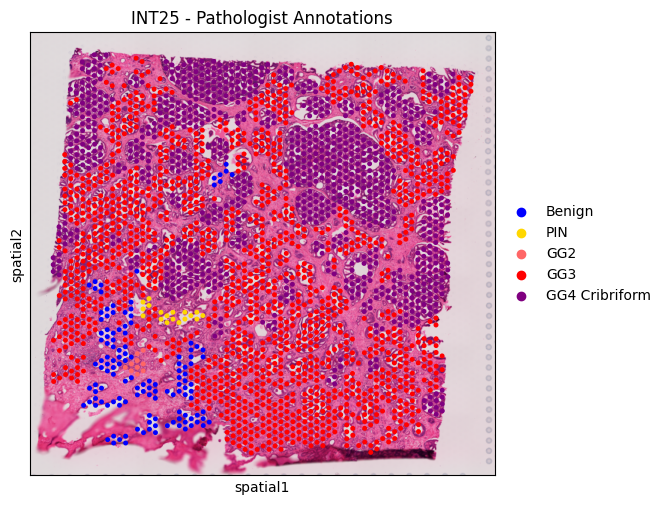

In [12]:
adata_copy = adata.copy()
category_order_copy = [color for color in category_order if color in label_orig_uniq]
adata_copy.obs['Label_orig'] = pd.Categorical(
    adata_copy.obs['Label_orig'], 
    categories=category_order_copy,  # your desired order
    ordered=True
)

sc.pl.spatial(adata_copy,
                # show first 8 cell types
                color=['Label_orig'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                # cmap="viridis",
                palette = custom_color_map,
                title= sample + " - Pathologist Annotations",
                show=False,  # Do not show the plot yet
)
plt.savefig(sample + "_Pathologist_Annotations.png", dpi=300, bbox_inches='tight')
plt.show()

# Quality control

In [13]:
sc.pp.filter_cells(adata, min_genes = 100)
sc.pp.filter_genes(adata,min_cells=3)


# Remove spots with more than 20% mitochondrial genes --> indicates dead cells
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

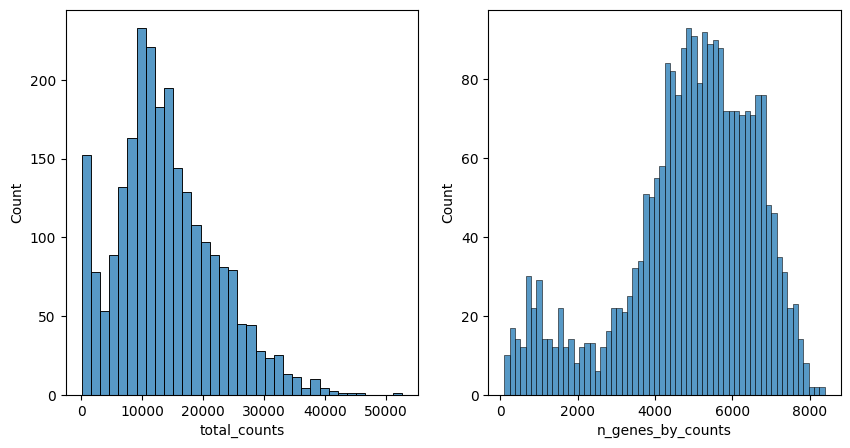

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

# Main pipeline

In [15]:
adata.layers['counts']=adata.X.copy()

adata = st.convert_scanpy(adata, use_quality = 'downscaled_fullres').copy()

adata = preprocess(adata, louvain_resolution = 0.5,  n_top_genes = n_top_genes, n_comps = n_comps,
                   diffmap = diffmap, remove_outliers = True, scale = True, outliers_percentage = outliers_percentage)


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


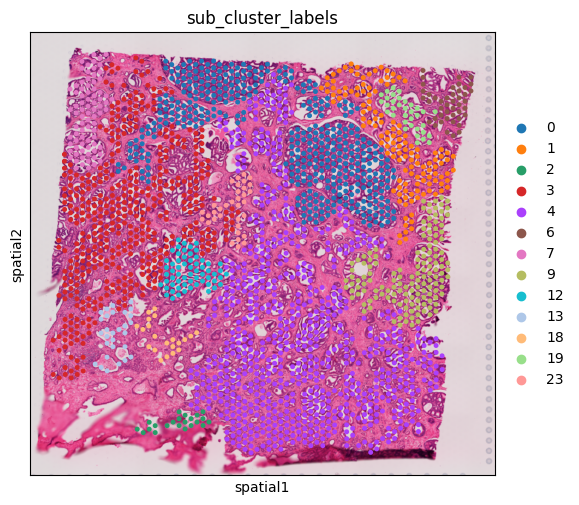

In [16]:
eps = 20 #How big subclusters will be created; The lower number the more subclusters
threshold_spots = 20 #Remove clusters with less then this many spots

adata.obs['Label_orig'] = (adata.obs['Label_orig']).astype('object').astype('category')

localization(adata, use_label='Label_orig', eps=eps)
adata = filter_cells(adata, 'sub_cluster_labels', threshold = threshold_spots)

sc.pl.spatial(adata,
                # show first 8 cell types
                color=['sub_cluster_labels'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis"
                )

In [17]:
root_cluster = 'Benign' # The cluster that corresponds to the early stage of cancer (benign cells)


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\stlearn\spatials\trajectory\set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr


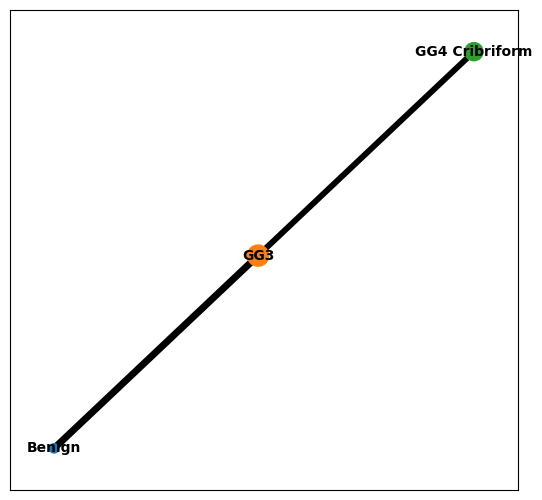

In [18]:
sc.tl.paga(adata, groups='Label_orig')
sc.pl.paga(adata, threshold=paga_threshold, show=False)
sc.tl.draw_graph(adata, init_pos="paga")

adata.uns["iroot"] = st.spatial.trajectory.set_root(adata,use_label='Label_orig',cluster=root_cluster, use_raw = False)

sc.tl.dpt(adata)


C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


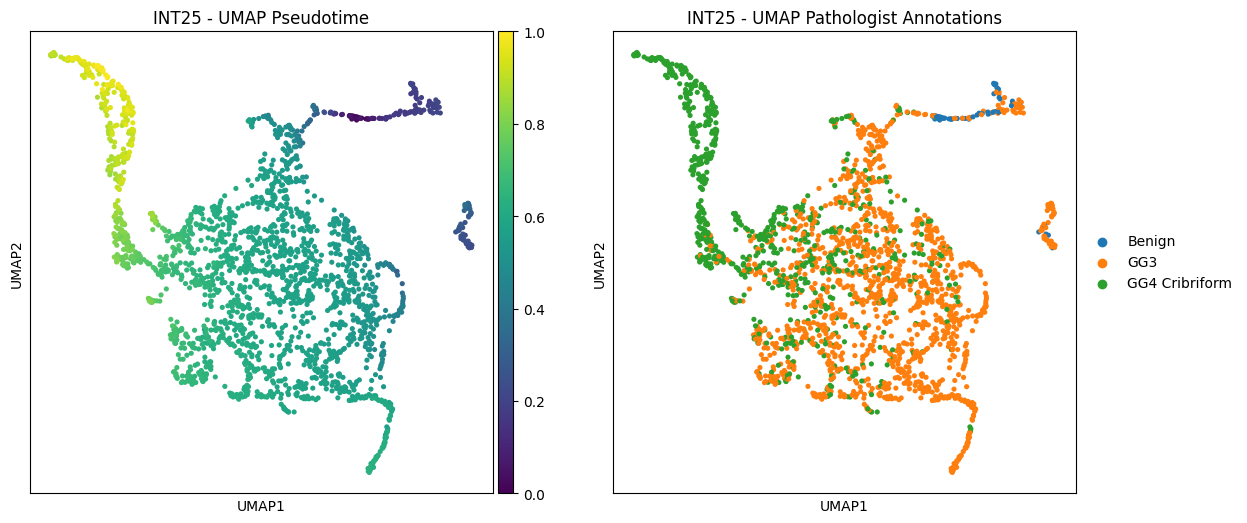

In [19]:
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['dpt_pseudotime', 'Label_orig'], title = [sample + " - UMAP Pseudotime",sample + " - UMAP Pathologist Annotations"] )

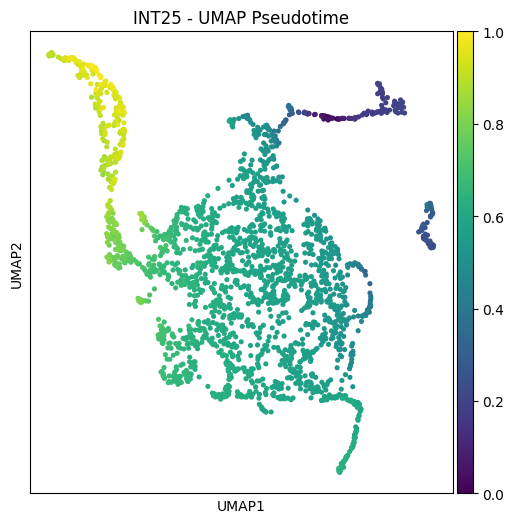

In [20]:
sc.pl.umap(
    adata, 
    color='dpt_pseudotime', 
    title=sample + " - UMAP Pseudotime",
    show=False,  # Do not show the plot yet
    )
plt.savefig(sample + "_UMAP_Pseudotime.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


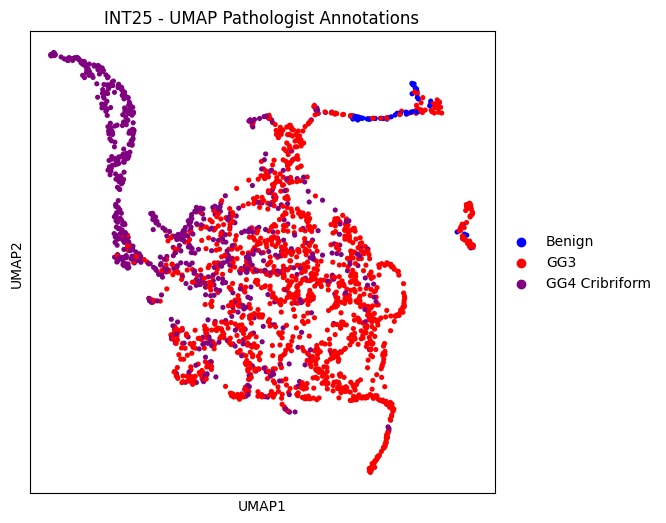

In [21]:
adata_copy = adata.copy()
category_order_copy = [color for color in category_order if color in label_orig_uniq]
adata_copy.obs['Label_orig'] = pd.Categorical(
    adata_copy.obs['Label_orig'], 
    categories=category_order_copy,  # your desired order
    ordered=True
)
sc.pl.umap(
    adata, 
    color='Label_orig', 
    title=sample + " - UMAP Pathologist Annotations",
    palette = custom_color_map,
    show=False,  # Do not show the plot yet
    )
plt.savefig(sample + "_UMAP_Pathologist_Annotations.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
adata.obs.index

Index(['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1',
       'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGGTAGGTACC-1',
       'AAACCTAAGCAGCCGG-1', 'AAACCTCATGAAGTTG-1', 'AAACGAGACGGTTGAT-1',
       'AAACGCCCGAGATCGG-1',
       ...
       'TTGGGCGGCGGTTGCC-1', 'TTGTAACTTCATAGCG-1', 'TTGTGAACCTAATCCG-1',
       'TTGTGCAGCCACGTCA-1', 'TTGTGGCCCTGACAGT-1', 'TTGTGTATGCCACCAA-1',
       'TTGTGTTTCCCGAAAG-1', 'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=2172)

In [23]:
# adata_analysis_final = adata_analysis_final[adata.obs.index]

# # Step 2: List of genes of interest
# genes_of_interest = ['TMEFF2', 'SPON2', 'CRISP3', 'TRGC1', 'MYO6', 'STEAP2', 'RPS8', 'RPS4X',
#               'EEF1G', 'KLK3', 'NPY', 'KLK2', 'IGKC', 'MT2A', 'NEFH',
#               'LGALS1', 'HLA-E', 'C1R', 'HLA-A', 'HLA-DRA', 'IGFBP7', 'DES', 'COL1A2',
#               'LGALS3BP', 'HSPB1', 'GSTP1', 'AZGP1', 'IFITM3', 'TAGLN', 'ACTG2',
#               'B2M', 'FLNA', 'MYL9', 'CD74', 'TPM2', 'ACTA2', 'S100A6', 'MSMB',
#               'TIMP1']

# # Step 3: Initialize an empty DataFrame with the cell names as index
# gene_expression_df = pd.DataFrame(index=adata_analysis_final.obs_names)

# # Loop over the list of genes and add them as columns to the DataFrame
# for gene in genes_of_interest:
#     if gene in adata_analysis_final.var_names:
#         # Extract the index of the gene in var_names
#         gene_index = adata_analysis_final.var_names.get_loc(gene)
        
#         # Extract the expression values for the gene across all cells
#         gene_expression_df[gene] = adata_analysis_final.X[:, gene_index].toarray().flatten() if hasattr(adata_analysis_final.X, "toarray") else adata_analysis_final.X[:, gene_index]
#     else:
#         # If the gene is not present, fill the column with NaN
#         gene_expression_df[gene] = np.nan

# gene_expression_df["Label_orig"] = adata_analysis_final.obs["Label_orig"]
# gene_expression_df["Sample"] = sample
# data_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
# gene_expression_df.to_csv(data_path + sample + '_summary_AfterOutliers_InterestingGenes.csv')
# print(gene_expression_df)

C:\Users\dandia\AppData\Local\Temp\ipykernel_25276\4168710238.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label_orig', y='dpt_pseudotime', data=df,palette = custom_color_map,)


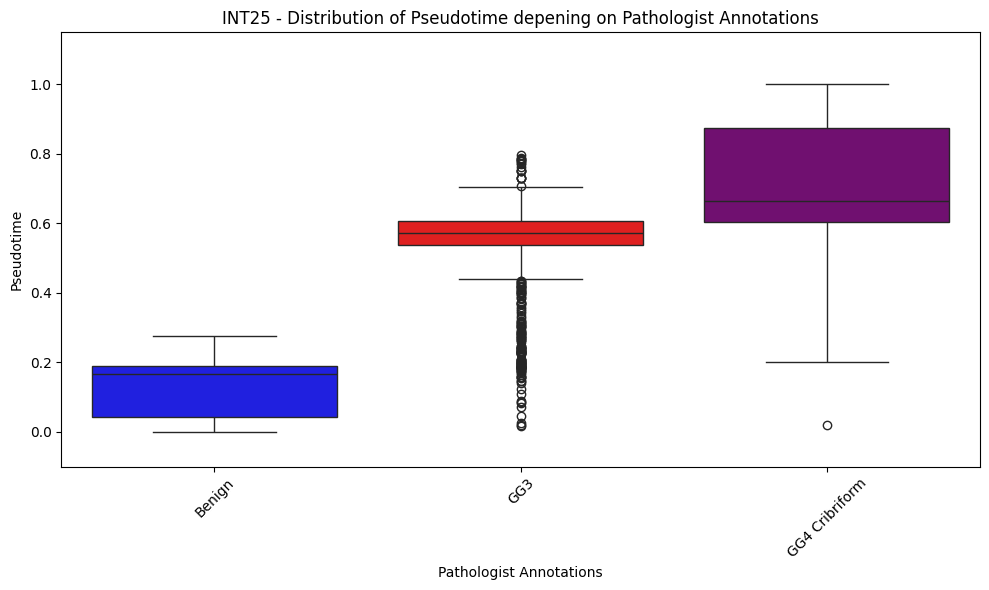

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the data by combining the categorical and numerical data into a DataFrame
df = pd.DataFrame({
    'Label_orig': adata_copy.obs['Label_orig'],    # Categorical variable
    'dpt_pseudotime': adata_copy.obs['dpt_pseudotime']  # Numerical variable
})

df['Label_orig'] = df['Label_orig'].cat.remove_unused_categories()

# Create a boxplot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label_orig', y='dpt_pseudotime', data=df,palette = custom_color_map,)

# Customize the plot
plt.title(sample + ' - Distribution of Pseudotime depening on Pathologist Annotations')
plt.xlabel('Pathologist Annotations')
plt.ylabel('Pseudotime')
plt.xticks(rotation=45)
plt.ylim(-0.10,1.15)
plt.tight_layout()

plt.savefig(sample + "_Distr_Pt_Pathologist_Annotations.png", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


In [25]:
adata.obs['n_genes_by_counts'].sum()

11012599

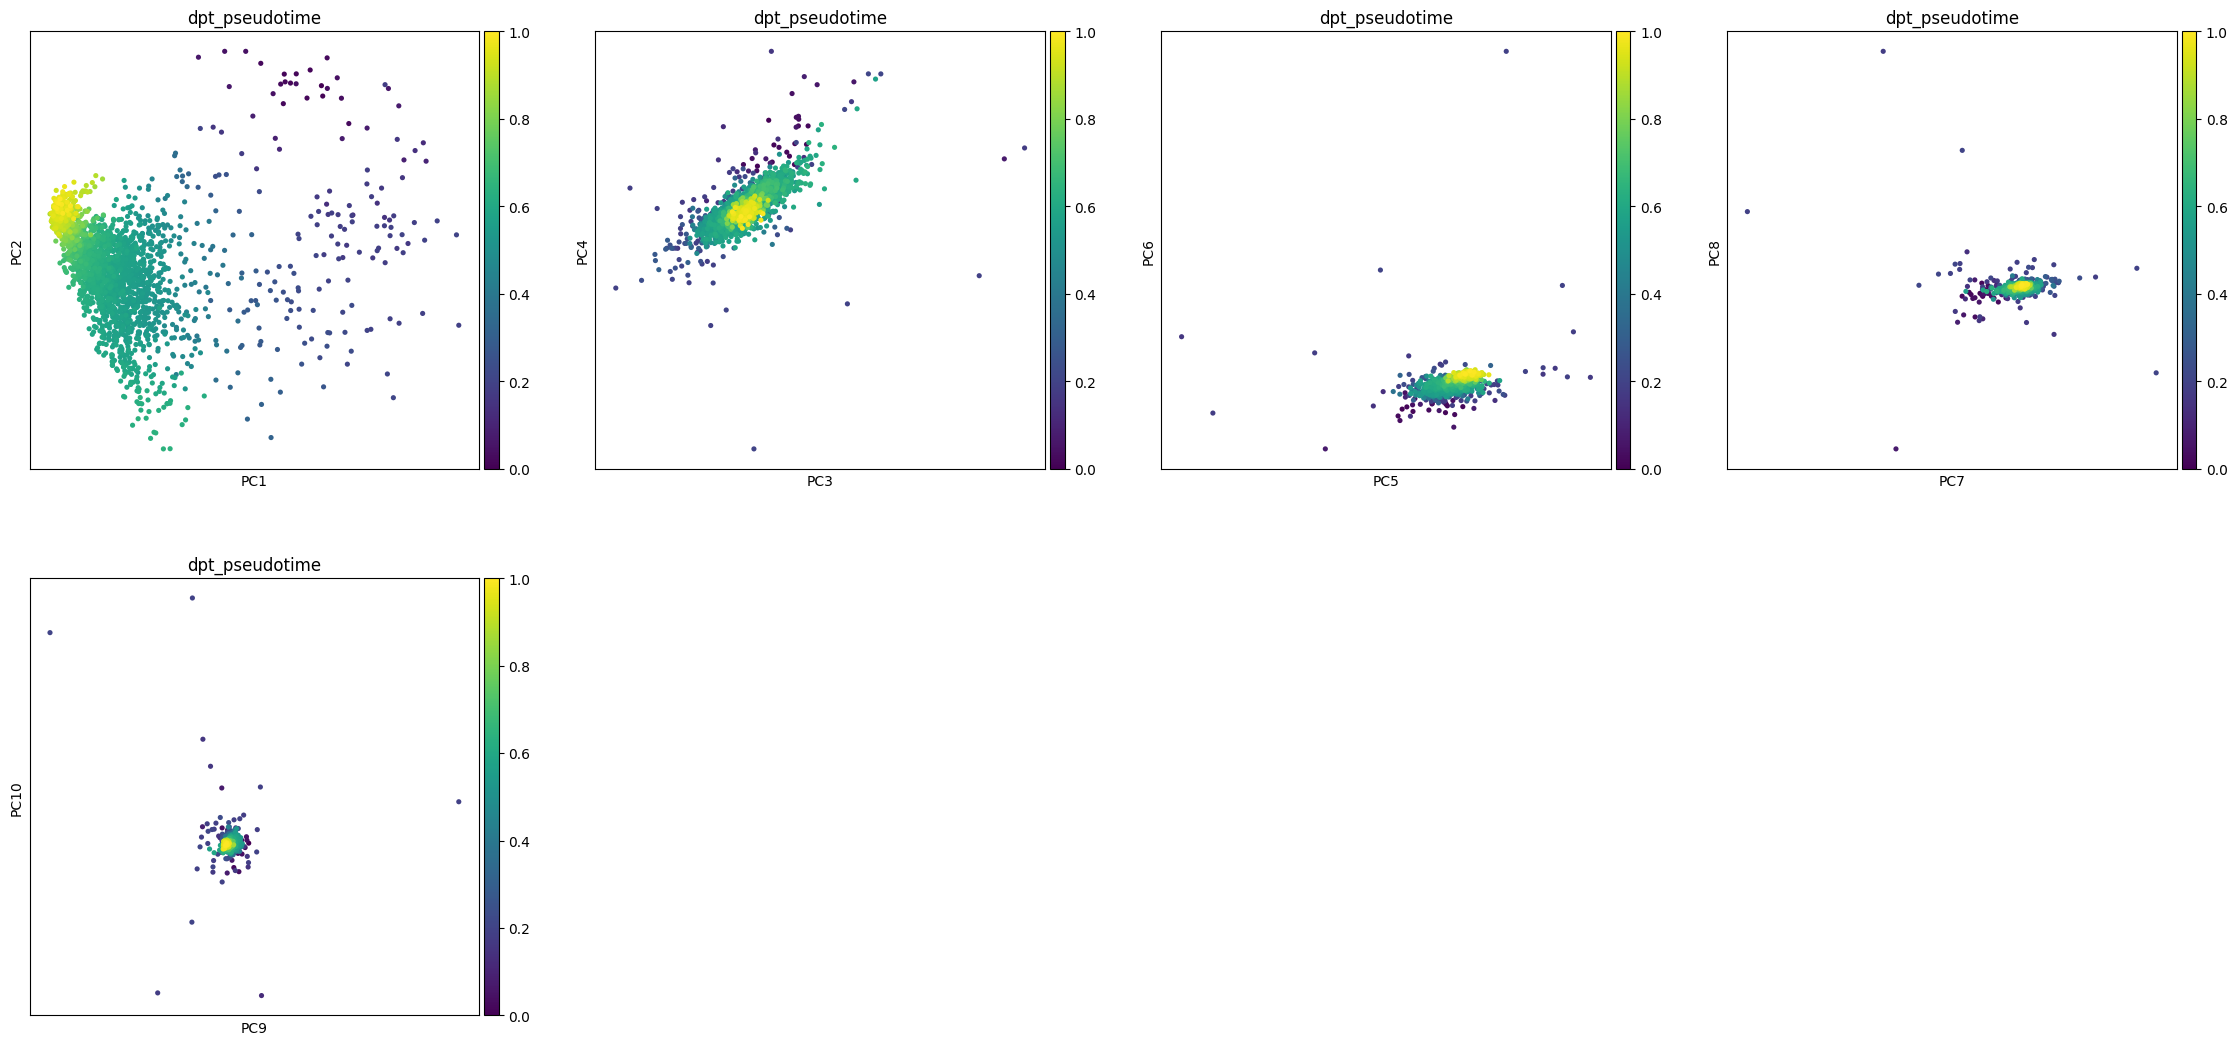

In [26]:
sc.pl.pca(adata, color="dpt_pseudotime", components=['1,2', '3,4', '5,6', '7,8', '9,10']) 

C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\dandia\AppData\Local\anaconda3\envs\stlearnLatest\lib\site-packages\scanpy\plot

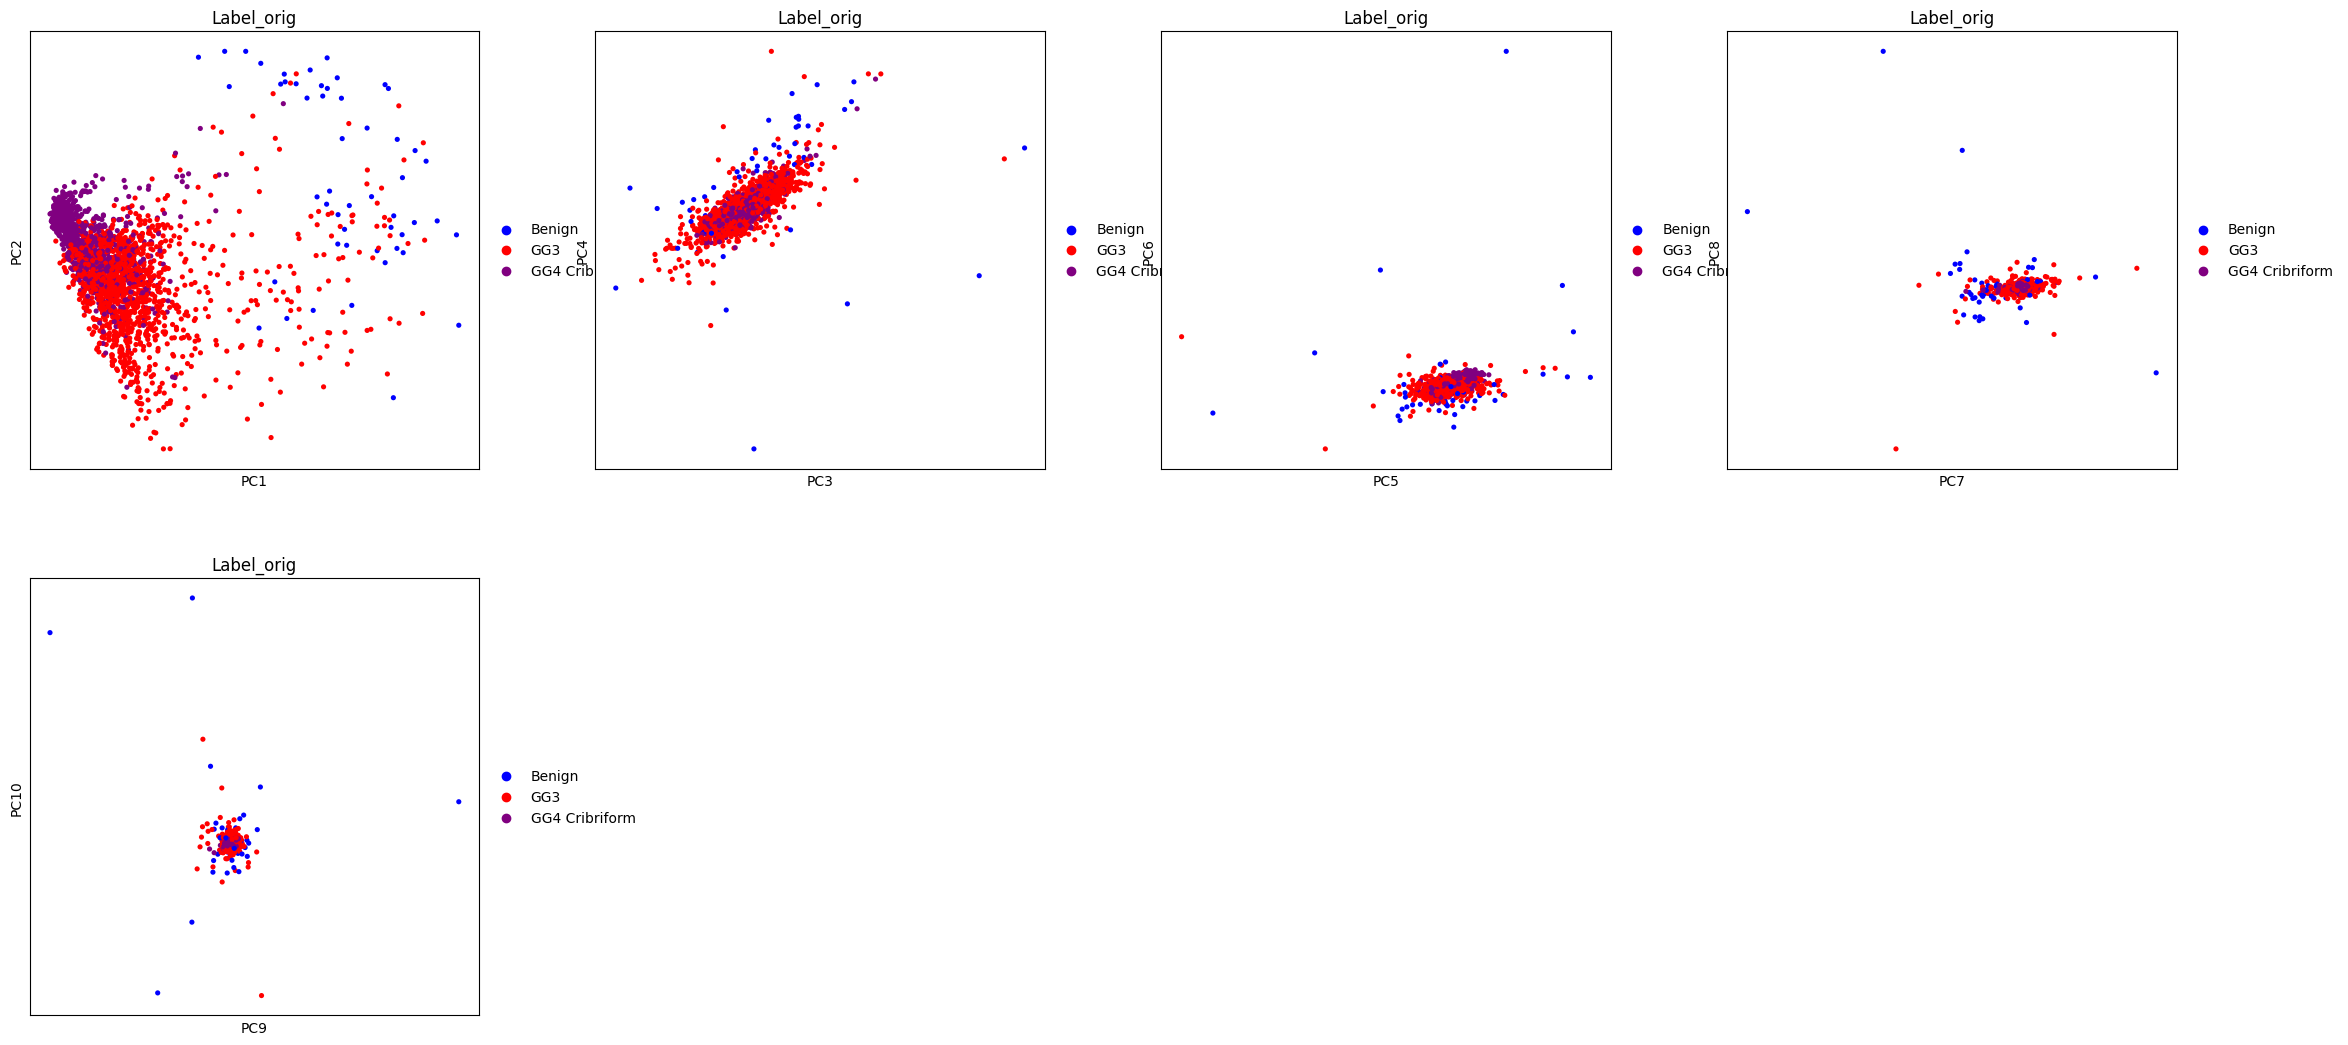

In [27]:
sc.pl.pca(adata, color="Label_orig", components=['1,2', '3,4', '5,6', '7,8', '9,10']) 

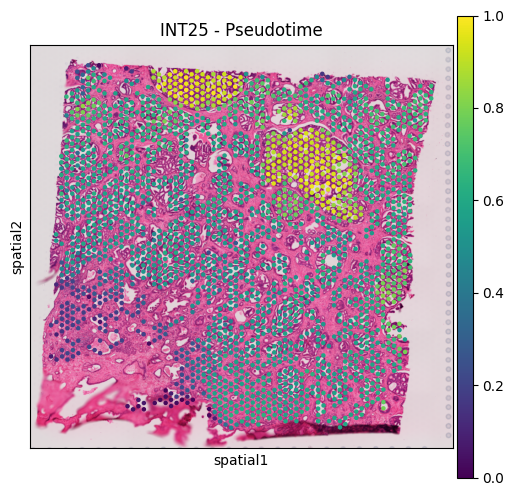

In [28]:
sc.pl.spatial(adata,
                # show first 8 cell types
                color='dpt_pseudotime',
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis",
                title = sample + " - Pseudotime",
                show=False,  # Do not show the plot yet
)
plt.savefig(sample + "_Pseudotime.png", dpi=300, bbox_inches='tight')
plt.show()

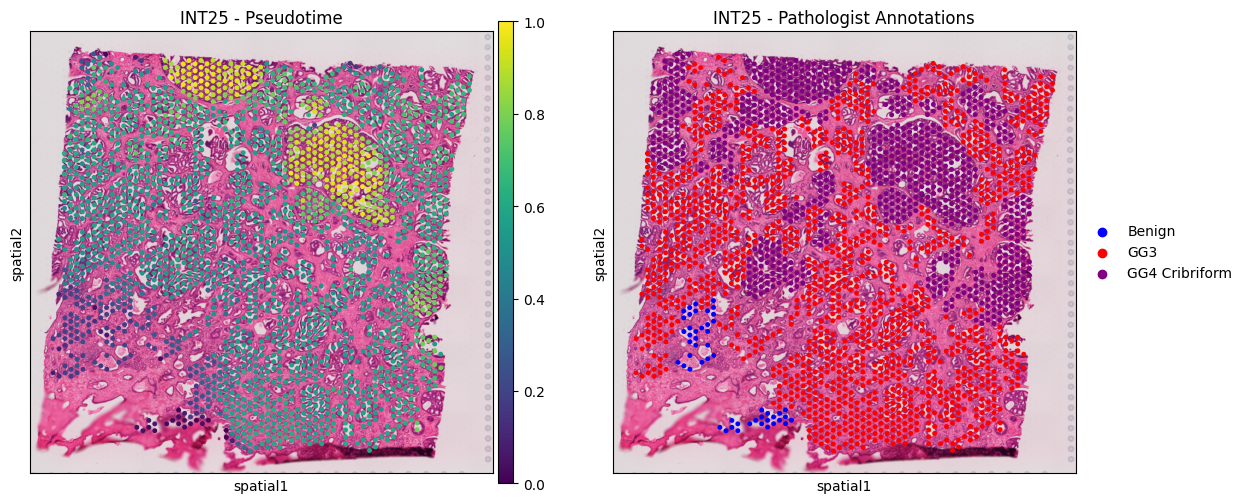

In [29]:
sc.pl.spatial(adata,
                # show first 8 cell types
                color=['dpt_pseudotime', 'Label_orig'],
                ncols=4, size=1.3,
                img_key="downscaled_fullres",
                # limit color scale at 99.2% quantile of cell abundance
                vmin=0, vmax=1,
                spot_size = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'],
                cmap="viridis",
                title = [sample + " - Pseudotime", sample + " - Pathologist Annotations"]
                )


In [1067]:
# We transform the Histological Annotations into a number ranging from 0 to 6 depending on their malignancy
# Benign --> 0
# PIN --> 1
# GG1 --> 2
# GG2 --> 3
# GG3 --> 4
# GG4 --> 5
# GG4 Cribriform --> 6
adata = adata[~np.isinf(adata.obs['dpt_pseudotime'])]
adata.obs["Label_orig2"] = 0
adata.obs.loc[adata.obs["Label_orig"] == "PIN",'Label_orig2'] = 1
adata.obs.loc[adata.obs["Label_orig"] == "GG1",'Label_orig2'] = 2
adata.obs.loc[adata.obs["Label_orig"] == "GG2",'Label_orig2'] = 3
adata.obs.loc[adata.obs["Label_orig"] == "GG3",'Label_orig2'] = 4
adata.obs.loc[adata.obs["Label_orig"] == "GG4",'Label_orig2'] = 5
adata.obs.loc[adata.obs["Label_orig"] == "GG4 Cribriform",'Label_orig2'] = 6
adata.obs

C:\Users\dandia\AppData\Local\Temp\ipykernel_5616\3221505934.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Label_orig2"] = 0


in_tissue  array_row  array_col  pxl_row_in_fullres  \
AAACAGAGCGACTCCT-1          1         14         94                7294   
AAACAGCTTTCAGAAG-1          1         43          9               14592   
AAACGAAGAACATACC-1          1          6         64                5264   
AAACGAGACGGTTGAT-1          1         35         79               12593   
AAACTTGCAAACGTAT-1          1         45         19               15100   
...                       ...        ...        ...                 ...   
TTGTGTATGCCACCAA-1          1         56         60               17891   
TTGTTCAGTGTGCTAC-1          1         24         64                9810   
TTGTTGTGTGTCAAGA-1          1         31         77               11582   
TTGTTTCACATCCAGG-1          1         58         42               18391   
TTGTTTGTGTAAATTC-1          1          7         51                5513   

                    pxl_col_in_fullres  n_genes_by_counts  \
AAACAGAGCGACTCCT-1               18767               4660   
AAACAGCTTTCAGAAG-1                6414               6436   
AAACGAAGAACATACC-1               14417               6860   
AAACGAGACGGTTGAT-1               16579               6168   
AAACTTGCAAACGTAT-1                7864               5786   
...                                ...                ...   
TTGTGTATGCCACCAA-1               13810               4614   
TTGTTCAGTGTGCTAC-1               14407               7353   
TTGTTGTGTGTCAAGA-1               16291               5602   
TTGTTTCACATCCAGG-1               11196               2820   
TTGTTTGTGTAAATTC-1               12529               6104   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAGAGCGACTCCT-1                 8.446985        9192.0            9.126198   
AAACAGCTTTCAGAAG-1                 8.769818       18036.0            9.800180   
AAACGAAGAACATACC-1                 8.833608       21192.0            9.961426   
AAACGAGACGGTTGAT-1                 8.727292       16298.0            9.698859   
AAACTTGCAAACGTAT-1                 8.663369       14928.0            9.611061   
...                                     ...           ...                 ...   
TTGTGTATGCCACCAA-1                 8.437067        9512.0            9.160415   
TTGTTCAGTGTGCTAC-1                 8.903000       23865.0           10.080210   
TTGTTGTGTGTCAAGA-1                 8.631057       13016.0            9.474011   
TTGTTTCACATCCAGG-1                 7.944847        4509.0            8.414052   
TTGTTTGTGTAAATTC-1                 8.716863       15005.0            9.616205   

                    pct_counts_in_top_50_genes  ...  n_genes  total_counts_mt  \
AAACAGAGCGACTCCT-1                   11.858138  ...     4660              0.0   
AAACAGCTTTCAGAAG-1                   15.263917  ...     6437              0.0   
AAACGAAGAACATACC-1                   18.615515  ...     6860              0.0   
AAACGAGACGGTTGAT-1                   16.732114  ...     6168              0.0   
AAACTTGCAAACGTAT-1                   12.372722  ...     5787              0.0   
...                                        ...  ...      ...              ...   
TTGTGTATGCCACCAA-1                   13.887721  ...     4614              0.0   
TTGTTCAGTGTGCTAC-1                   12.729939  ...     7354              0.0   
TTGTTGTGTGTCAAGA-1                   14.758758  ...     5603              0.0   
TTGTTTCACATCCAGG-1                   17.587048  ...     2821              0.0   
TTGTTTGTGTAAATTC-1                   13.608797  ...     6105              0.0   

                    log1p_total_counts_mt  pct_counts_mt    imagecol  \
AAACAGAGCGACTCCT-1                    0.0            0.0  683.131916   
AAACAGCTTTCAGAAG-1                    0.0            0.0  233.474083   
AAACGAAGAACATACC-1                    0.0            0.0  524.788876   
AAACGAGACGGTTGAT-1                    0.0            0.0  603.487187   
AAACTTGCAAACGTAT-1                    0.0            0.0  286.255096   
...     

In [1068]:
correlation_result = spearmanr(adata.obs["Label_orig2"] , adata.obs["dpt_pseudotime"])
print("Correlation =", correlation_result.statistic, "with p-value", correlation_result.pvalue)

Correlation = 0.11443195198894707 with p-value 6.333491790925155e-06


In [1069]:
PT_df = adata.obs[["Label_orig","Label_orig2","dpt_pseudotime"]]
data_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
PT_df.to_csv(data_path + sample + "_HA_PT.csv")

In [1070]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=adata.obs["dpt_pseudotime"], groups=adata.obs["Label_orig"], alpha=0.05)
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
tukey_df.to_csv( sample + "_tukey_hsd_results.csv", index=False)
print(tukey)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1     group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------
Benign            GG3   0.1887    0.0  0.0832 0.2942   True
Benign            GG4   0.2152    0.0  0.1161 0.3142   True
Benign GG4 Cribriform   0.2893    0.0   0.193 0.3857   True
   GG3            GG4   0.0265 0.5759 -0.0267 0.0797  False
   GG3 GG4 Cribriform   0.1007    0.0  0.0527 0.1486   True
   GG4 GG4 Cribriform   0.0742    0.0  0.0428 0.1056   True
-----------------------------------------------------------


In [1071]:
from matplotlib.backends.backend_pdf import PdfPages

# Create a matplotlib figure with additional space for the header
fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted height for more space
ax.axis('off')  # Hide axis

# Add the header text with increased vertical space
header_text = "Multiple Comparison of Means - Tukey HSD, FWER=0.05"
plt.text(0.5, 1.0, header_text, ha='center', va='top', fontsize=12, fontweight='bold', transform=ax.transAxes)

# Display the Tukey HSD table
tbl = ax.table(cellText=tukey_df.values, colLabels=tukey_df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)  # Scale table for readability

# Save the figure to a PDF with increased space for title
with PdfPages(sample + "_tukey_hsd_results.pdf") as pdf:
    pdf.savefig(fig, bbox_inches="tight")
plt.close(fig)  # Close the figure after saving

In [1072]:
print(adata.obs['dpt_pseudotime'].dtype) 
print(np.isinf(adata.obs['dpt_pseudotime']).any())

float32
False


In [1002]:
adata.obs.loc[np.isinf(adata.obs['dpt_pseudotime']),:]

Empty DataFrame
Columns: [in_tissue, array_row, array_col, pxl_row_in_fullres, pxl_col_in_fullres, n_genes_by_counts, log1p_n_genes_by_counts, total_counts, log1p_total_counts, pct_counts_in_top_50_genes, pct_counts_in_top_100_genes, pct_counts_in_top_200_genes, pct_counts_in_top_500_genes, total_counts_mito, log1p_total_counts_mito, pct_counts_mito, Label_orig, n_genes, total_counts_mt, log1p_total_counts_mt, pct_counts_mt, imagecol, imagerow, louvain, sub_cluster_labels, dpt_pseudotime, Label_orig2]
Index: []

[0 rows x 27 columns]

In [930]:
import statistics
statistics.stdev(adata.obs.loc[adata.obs["Label_orig"] == "Benign",'dpt_pseudotime'])

0.09536471768740913

In [560]:
np.any(np.isnan(adata.obs.loc[adata.obs["Label_orig"] == "Benign",'dpt_pseudotime']))

False

# CNV HEATMAP with PT and Annotations

In [85]:
data.iloc[:, 3:]


AAACAACGAATAGTTC.1  AAACAGAGCGACTCCT.1  \
1                            -0.061706            0.096527   
2                            -0.061706            0.096527   
3                            -0.061706            0.096527   
AAACAACGAATAGTTC-1           -0.061706            0.096527   
AAACAGAGCGACTCCT-1           -0.061706            0.096527   
...                                ...                 ...   
12163                        -0.053313            0.022941   
12164                        -0.053313            0.022941   
12165                        -0.053313            0.022941   
12166                        -0.053313            0.022941   
12167                        -0.053313            0.022941   

                    AAACCGTTCGTCCAGG.1  AAACCTCATGAAGTTG.1  \
1                            -0.000243           -0.038379   
2                            -0.000243           -0.038379   
3                            -0.000243           -0.038379   
AAACAACGAATAGTTC-1           -0.000243           -0.038379   
AAACAGAGCGACTCCT-1           -0.000243           -0.038379   
...                                ...                 ...   
12163                        -0.000243            0.041096   
12164                        -0.000243            0.041096   
12165                        -0.000243            0.041096   
12166                        -0.000243            0.041096   
12167                        -0.000243            0.041096   

                    AAACGAGACGGTTGAT.1  AAACGGGTTGGTATCC.1  \
1                            -0.034336            0.045090   
2                            -0.034336            0.045090   
3                            -0.034336            0.045090   
AAACAACGAATAGTTC-1           -0.034336            0.045090   
AAACAGAGCGACTCCT-1           -0.034336            0.045090   
...                                ...                 ...   
12163                         0.059248            0.065415   
12164                         0.059248            0.065415   
12165                         0.059248            0.065415   
12166                         0.059248            0.065415   
12167                         0.059248            0.065415   

                    AAACTTGCAAACGTAT.1  AAAGGCTCTCGCGCCG.1  \
1                            -0.089780           -0.000091   
2                            -0.089780           -0.000091   
3                            -0.089780           -0.000091   
AAACAACGAATAGTTC-1           -0.089780           -0.000091   
AAACAGAGCGACTCCT-1           -0.089780           -0.000091   
...                                ...                 ...   
12163                         0.015549            0.045221   
12164                         0.015549            0.045221   
12165                         0.015549            0.045221   
12166                         0.015549            0.045221   
12167                         0.015549            0.045221   

                    AAAGGGATGTAGCAAG.1  AAAGTAGCATTGCTCA.1  ...  \
1                            -0.081407            0.188734  ...   
2                            -0.081407            0.188734  ...   
3                            -0.081407            0.188734  ...   
AAACAACGAATAGTTC-1           -0.081407            0.188734  ...   
AAACAGAGCGACTCCT-1           -0.081407            0.188734  ...   
...                                ...                 ...  ...   
12163                         0.026813            0.096795  ...   
12164                         0.026813            0.096795  ...   
12165                         0.026813            0.096795  ...   
12166                         0.026813            0.096795  ...   
12167                         0.026813            0.096795  ...   

                    TTGTGGCCCTGACAGT.1  TTGTGGTAGGAGGGAT.1  \
1                             0.000049           -0.037443   
2                             0.000049           -0.037443   
3                             0.000049           

In [90]:
input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/CopyKatDataPlots/MEND160/16/'
data = pd.read_csv(input_path + 'MEND160_1_CNVsMatrix16.csv', index_col = 0)
data = data.iloc[:, 3:]
data.index = [i for i in range(1,len(data.index)+1)]
data = np.transpose(data)
data.index = data.index.str.replace('.', '-', regex=False)
data

C:\Users\dandia\AppData\Local\Temp\ipykernel_16432\800006635.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_path + 'MEND160_1_CNVsMatrix16.csv', index_col = 0)


1         2         3         4         5      \
AAACAACGAATAGTTC-1 -0.061706 -0.061706 -0.061706 -0.061706 -0.061706   
AAACAGAGCGACTCCT-1  0.096527  0.096527  0.096527  0.096527  0.096527   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243   
AAACCTCATGAAGTTG-1 -0.038379 -0.038379 -0.038379 -0.038379 -0.038379   
AAACGAGACGGTTGAT-1 -0.034336 -0.034336 -0.034336 -0.034336 -0.034336   
...                      ...       ...       ...       ...       ...   
TTGTGTATGCCACCAA-1  0.058792  0.058792  0.058792  0.058792  0.058792   
TTGTGTTTCCCGAAAG-1  0.000235  0.000235  0.000235  0.000235  0.000235   
TTGTTCAGTGTGCTAC-1 -0.023187 -0.023187 -0.023187 -0.023187 -0.023187   
TTGTTGTGTGTCAAGA-1 -0.019633 -0.019633 -0.019633 -0.019633 -0.019633   
TTGTTTGTGTAAATTC-1  0.047399  0.047399  0.047399  0.047399  0.047399   

                       6         7         8         9         10     ...  \
AAACAACGAATAGTTC-1 -0.061706 -0.061706 -0.061706 -0.061706 -0.061706  ...   
AAACAGAGCGACTCCT-1  0.096527  0.096527  0.096527  0.096527  0.096527  ...   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243  ...   
AAACCTCATGAAGTTG-1 -0.038379 -0.038379 -0.038379 -0.038379 -0.038379  ...   
AAACGAGACGGTTGAT-1 -0.034336 -0.034336 -0.034336 -0.034336 -0.034336  ...   
...                      ...       ...       ...       ...       ...  ...   
TTGTGTATGCCACCAA-1  0.058792  0.058792  0.058792  0.058792  0.058792  ...   
TTGTGTTTCCCGAAAG-1  0.000235  0.000235  0.000235  0.000235  0.000235  ...   
TTGTTCAGTGTGCTAC-1 -0.023187 -0.023187 -0.023187 -0.023187 -0.023187  ...   
TTGTTGTGTGTCAAGA-1 -0.019633 -0.019633 -0.019633 -0.019633 -0.019633  ...   
TTGTTTGTGTAAATTC-1  0.047399  0.047399  0.047399  0.047399  0.047399  ...   

                       12158     12159     12160     12161     12162  \
AAACAACGAATAGTTC-1 -0.053313 -0.053313 -0.053313 -0.053313 -0.053313   
AAACAGAGCGACTCCT-1  0.022941  0.022941  0.022941  0.022941  0.022941   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243   
AAACCTCATGAAGTTG-1  0.041096  0.041096  0.041096  0.041096  0.041096   
AAACGAGACGGTTGAT-1  0.059248  0.059248  0.059248  0.059248  0.059248   
...                      ...       ...       ...       ...       ...   
TTGTGTATGCCACCAA-1 -0.012986 -0.012986 -0.012986 -0.012986 -0.012986   
TTGTGTTTCCCGAAAG-1  0.063998  0.063998  0.063998  0.063998  0.063998   
TTGTTCAGTGTGCTAC-1  0.024997  0.024997  0.024997  0.024997  0.024997   
TTGTTGTGTGTCAAGA-1  0.037940  0.037940  0.037940  0.037940  0.037940   
TTGTTTGTGTAAATTC-1 -0.019109 -0.019109 -0.019109 -0.019109 -0.019109   

                       12163     12164     12165     12166     12167  
AAACAACGAATAGTTC-1 -0.053313 -0.053313 -0.053313 -0.053313 -0.053313  
AAACAGAGCGACTCCT-1  0.022941  0.022941  0.022941  0.022941  0.022941  
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243  
AAACCTCATGAAGTTG-1  0.041096  0.041096  0.041096  0.041096  0.041096  
AAACGAGACGGTTGAT-1  0.059248  0.059248  0.059248  0.059248  0.059248  
...                      ...       ...       ...       ...       ...  
TTGTGTATGCCACCAA-1 -0.012986 -0.012986 -0.012986 -0.012986 -0.012986  
TTGTGTTTCCCGAAAG-1  0.063998  0.063998  0.063998  0.063998  0.063998  
TTGTTCAGTGTGCTAC-1  0.024997  0.024997  0.024997  0.024997  0.024997  
TTGTTGTGTGTCAAGA-1  0.037940  0.037940  0.037940  0.037940  0.037940  
TTGTTTGTGTAAATTC-1 -0.019109 -0.019109 -0.019109 -0.019109 -0.019109  

[1464 rows x 12167 columns]

In [91]:
adata.obs[['dpt_pseudotime','Label_orig']]
adata.obs[['dpt_pseudotime']]

dpt_pseudotime
AAACAACGAATAGTTC-1        0.921654
AAACAGAGCGACTCCT-1        0.057704
AAACCGTTCGTCCAGG-1        0.400331
AAACCTCATGAAGTTG-1        0.426053
AAACGAGACGGTTGAT-1        0.403456
...                            ...
TTGTGGTAGGAGGGAT-1        0.407760
TTGTGTATGCCACCAA-1        0.403291
TTGTGTTTCCCGAAAG-1        0.411241
TTGTTAGCAAATTCGA-1        0.224614
TTGTTCAGTGTGCTAC-1        0.225540

[1355 rows x 1 columns]

In [92]:
data['dpt_pseudotime'] = adata.obs[['dpt_pseudotime']]
data['Label_orig'] = adata.obs[['Label_orig']]
data

1         2         3         4         5  \
AAACAACGAATAGTTC-1 -0.061706 -0.061706 -0.061706 -0.061706 -0.061706   
AAACAGAGCGACTCCT-1  0.096527  0.096527  0.096527  0.096527  0.096527   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243   
AAACCTCATGAAGTTG-1 -0.038379 -0.038379 -0.038379 -0.038379 -0.038379   
AAACGAGACGGTTGAT-1 -0.034336 -0.034336 -0.034336 -0.034336 -0.034336   
...                      ...       ...       ...       ...       ...   
TTGTGTATGCCACCAA-1  0.058792  0.058792  0.058792  0.058792  0.058792   
TTGTGTTTCCCGAAAG-1  0.000235  0.000235  0.000235  0.000235  0.000235   
TTGTTCAGTGTGCTAC-1 -0.023187 -0.023187 -0.023187 -0.023187 -0.023187   
TTGTTGTGTGTCAAGA-1 -0.019633 -0.019633 -0.019633 -0.019633 -0.019633   
TTGTTTGTGTAAATTC-1  0.047399  0.047399  0.047399  0.047399  0.047399   

                           6         7         8         9        10  ...  \
AAACAACGAATAGTTC-1 -0.061706 -0.061706 -0.061706 -0.061706 -0.061706  ...   
AAACAGAGCGACTCCT-1  0.096527  0.096527  0.096527  0.096527  0.096527  ...   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243  ...   
AAACCTCATGAAGTTG-1 -0.038379 -0.038379 -0.038379 -0.038379 -0.038379  ...   
AAACGAGACGGTTGAT-1 -0.034336 -0.034336 -0.034336 -0.034336 -0.034336  ...   
...                      ...       ...       ...       ...       ...  ...   
TTGTGTATGCCACCAA-1  0.058792  0.058792  0.058792  0.058792  0.058792  ...   
TTGTGTTTCCCGAAAG-1  0.000235  0.000235  0.000235  0.000235  0.000235  ...   
TTGTTCAGTGTGCTAC-1 -0.023187 -0.023187 -0.023187 -0.023187 -0.023187  ...   
TTGTTGTGTGTCAAGA-1 -0.019633 -0.019633 -0.019633 -0.019633 -0.019633  ...   
TTGTTTGTGTAAATTC-1  0.047399  0.047399  0.047399  0.047399  0.047399  ...   

                       12160     12161     12162     12163     12164  \
AAACAACGAATAGTTC-1 -0.053313 -0.053313 -0.053313 -0.053313 -0.053313   
AAACAGAGCGACTCCT-1  0.022941  0.022941  0.022941  0.022941  0.022941   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243   
AAACCTCATGAAGTTG-1  0.041096  0.041096  0.041096  0.041096  0.041096   
AAACGAGACGGTTGAT-1  0.059248  0.059248  0.059248  0.059248  0.059248   
...                      ...       ...       ...       ...       ...   
TTGTGTATGCCACCAA-1 -0.012986 -0.012986 -0.012986 -0.012986 -0.012986   
TTGTGTTTCCCGAAAG-1  0.063998  0.063998  0.063998  0.063998  0.063998   
TTGTTCAGTGTGCTAC-1  0.024997  0.024997  0.024997  0.024997  0.024997   
TTGTTGTGTGTCAAGA-1  0.037940  0.037940  0.037940  0.037940  0.037940   
TTGTTTGTGTAAATTC-1 -0.019109 -0.019109 -0.019109 -0.019109 -0.019109   

                       12165     12166     12167  dpt_pseudotime  \
AAACAACGAATAGTTC-1 -0.053313 -0.053313 -0.053313        0.921654   
AAACAGAGCGACTCCT-1  0.022941  0.022941  0.022941        0.057704   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243        0.400331   
AAACCTCATGAAGTTG-1  0.041096  0.041096  0.041096        0.426053   
AAACGAGACGGTTGAT-1  0.059248  0.059248  0.059248        0.403456   
...                      ...       ...       ...             ...   
TTGTGTATGCCACCAA-1 -0.012986 -0.012986 -0.012986        0.403291   
TTGTGTTTCCCGAAAG-1  0.063998  0.063998  0.063998        0.411241   
TTGTTCAGTGTGCTAC-1  0.024997  0.024997  0.024997        0.225540   
TTGTTGTGTGTCAAGA-1  0.037940  0.037940  0.037940             NaN   
TTGTTTGTGTAAATTC-1 -0.019109 -0.019109 -0.019109             NaN   

                        Label_orig  
AAACAACGAATAGTTC-1  GG4 Cribriform  
AAACAGAGCGACTCCT-1          Benign  
AAACCGTTCGTCCAGG-1             GG2  
AAACCTCATGAAGTTG-1             GG2  
AAACGAGACGGTTGAT-1             GG1  
...                            ...  
TTGTGTATGCCACCAA-1             GG2  
TTGTGTTTCCCGAAAG-1             GG2  
TTGTTCAGTGTGCTAC-1             GG1  
TTGTTGTGTGTCAAGA-1             NaN  
TTGTTTGTGTAAATTC-1             NaN  

[1464 rows x 12169 columns]

In [67]:
set(data["Label_orig"])

{'Benign', 'GG1', 'GG2', 'GG3', 'GG4 Cribriform', nan}

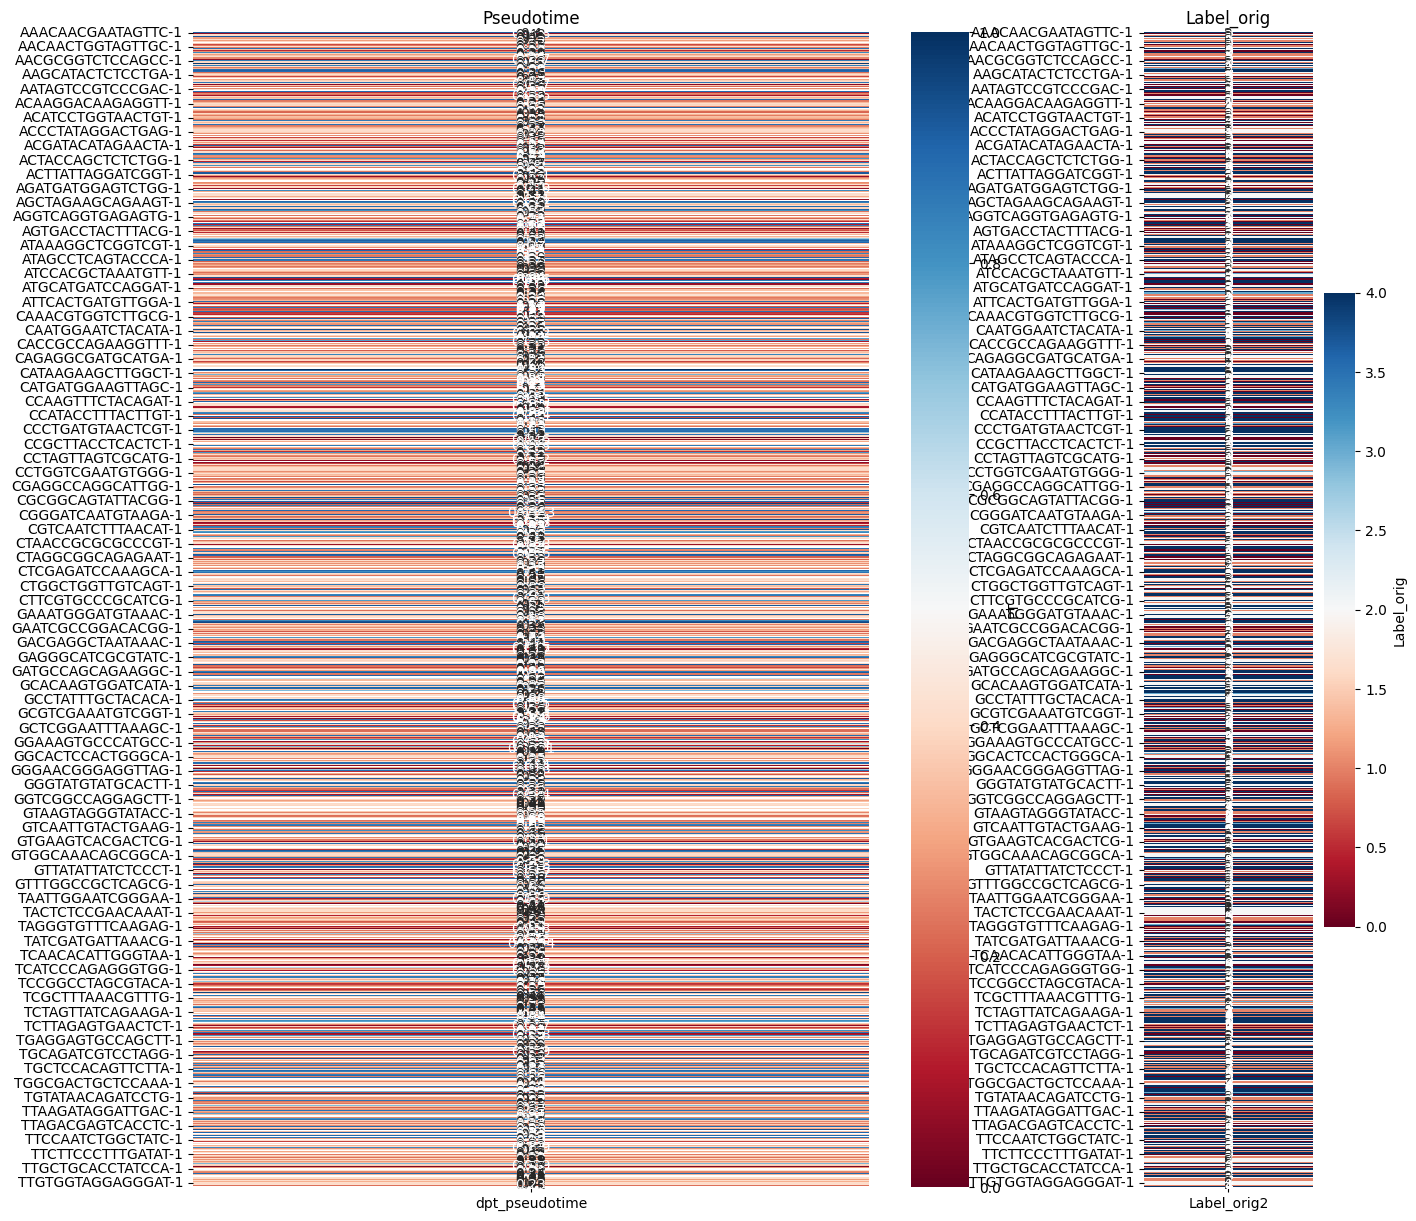

In [94]:
cols_colormap1 = [col for col in data.columns if col not in ['dpt_pseudotime','Label_orig','Label_orig2']]
cols_colormap2 = ['dpt_pseudotime']
cols_colormap3 = ['Label_orig2']
data["Label_orig2"] = 4

data.loc[data["Label_orig"] == "Benign",'Label_orig2'] = 0
data.loc[data["Label_orig"] == "GG1",'Label_orig2'] = 1
data.loc[data["Label_orig"] == "GG2",'Label_orig2'] = 2
data.loc[data["Label_orig"] == "GG3",'Label_orig2'] = 3
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15), gridspec_kw={'width_ratios': [0.8, 0.2]})

# Plot the first set of columns with the first colormap

# Plot the second set of columns with the second colormap
sns.heatmap(data[cols_colormap2], ax=axes[0], cmap='RdBu', annot=True, linewidths=0, linecolor='black', cbar_kws={'label': 'PT'})
axes[0].set_title('Pseudotime')

# Plot the second set of columns with the second colormap
sns.heatmap(data[cols_colormap3], ax=axes[1], cmap='RdBu', annot=True, linewidths=0, linecolor='black', cbar_kws={'label': 'Label_orig'})
axes[1].set_title('Label_orig')

# Show the plot
plt.show()

In [96]:
data2 = data[[col for col in data.columns if col != "Label_orig2"]].copy()
input_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/DATA/'
data2.to_csv(input_path + sample + '_heatmapData.csv')

In [97]:
data[[col for col in data.columns if col != "Label_orig2"]]

1         2         3         4         5  \
AAACAACGAATAGTTC-1 -0.061706 -0.061706 -0.061706 -0.061706 -0.061706   
AAACAGAGCGACTCCT-1  0.096527  0.096527  0.096527  0.096527  0.096527   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243   
AAACCTCATGAAGTTG-1 -0.038379 -0.038379 -0.038379 -0.038379 -0.038379   
AAACGAGACGGTTGAT-1 -0.034336 -0.034336 -0.034336 -0.034336 -0.034336   
...                      ...       ...       ...       ...       ...   
TTGTGTATGCCACCAA-1  0.058792  0.058792  0.058792  0.058792  0.058792   
TTGTGTTTCCCGAAAG-1  0.000235  0.000235  0.000235  0.000235  0.000235   
TTGTTCAGTGTGCTAC-1 -0.023187 -0.023187 -0.023187 -0.023187 -0.023187   
TTGTTGTGTGTCAAGA-1 -0.019633 -0.019633 -0.019633 -0.019633 -0.019633   
TTGTTTGTGTAAATTC-1  0.047399  0.047399  0.047399  0.047399  0.047399   

                           6         7         8         9        10  ...  \
AAACAACGAATAGTTC-1 -0.061706 -0.061706 -0.061706 -0.061706 -0.061706  ...   
AAACAGAGCGACTCCT-1  0.096527  0.096527  0.096527  0.096527  0.096527  ...   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243  ...   
AAACCTCATGAAGTTG-1 -0.038379 -0.038379 -0.038379 -0.038379 -0.038379  ...   
AAACGAGACGGTTGAT-1 -0.034336 -0.034336 -0.034336 -0.034336 -0.034336  ...   
...                      ...       ...       ...       ...       ...  ...   
TTGTGTATGCCACCAA-1  0.058792  0.058792  0.058792  0.058792  0.058792  ...   
TTGTGTTTCCCGAAAG-1  0.000235  0.000235  0.000235  0.000235  0.000235  ...   
TTGTTCAGTGTGCTAC-1 -0.023187 -0.023187 -0.023187 -0.023187 -0.023187  ...   
TTGTTGTGTGTCAAGA-1 -0.019633 -0.019633 -0.019633 -0.019633 -0.019633  ...   
TTGTTTGTGTAAATTC-1  0.047399  0.047399  0.047399  0.047399  0.047399  ...   

                       12160     12161     12162     12163     12164  \
AAACAACGAATAGTTC-1 -0.053313 -0.053313 -0.053313 -0.053313 -0.053313   
AAACAGAGCGACTCCT-1  0.022941  0.022941  0.022941  0.022941  0.022941   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243 -0.000243 -0.000243   
AAACCTCATGAAGTTG-1  0.041096  0.041096  0.041096  0.041096  0.041096   
AAACGAGACGGTTGAT-1  0.059248  0.059248  0.059248  0.059248  0.059248   
...                      ...       ...       ...       ...       ...   
TTGTGTATGCCACCAA-1 -0.012986 -0.012986 -0.012986 -0.012986 -0.012986   
TTGTGTTTCCCGAAAG-1  0.063998  0.063998  0.063998  0.063998  0.063998   
TTGTTCAGTGTGCTAC-1  0.024997  0.024997  0.024997  0.024997  0.024997   
TTGTTGTGTGTCAAGA-1  0.037940  0.037940  0.037940  0.037940  0.037940   
TTGTTTGTGTAAATTC-1 -0.019109 -0.019109 -0.019109 -0.019109 -0.019109   

                       12165     12166     12167  dpt_pseudotime  \
AAACAACGAATAGTTC-1 -0.053313 -0.053313 -0.053313        0.921654   
AAACAGAGCGACTCCT-1  0.022941  0.022941  0.022941        0.057704   
AAACCGTTCGTCCAGG-1 -0.000243 -0.000243 -0.000243        0.400331   
AAACCTCATGAAGTTG-1  0.041096  0.041096  0.041096        0.426053   
AAACGAGACGGTTGAT-1  0.059248  0.059248  0.059248        0.403456   
...                      ...       ...       ...             ...   
TTGTGTATGCCACCAA-1 -0.012986 -0.012986 -0.012986        0.403291   
TTGTGTTTCCCGAAAG-1  0.063998  0.063998  0.063998        0.411241   
TTGTTCAGTGTGCTAC-1  0.024997  0.024997  0.024997        0.225540   
TTGTTGTGTGTCAAGA-1  0.037940  0.037940  0.037940             NaN   
TTGTTTGTGTAAATTC-1 -0.019109 -0.019109 -0.019109             NaN   

                        Label_orig  
AAACAACGAATAGTTC-1  GG4 Cribriform  
AAACAGAGCGACTCCT-1          Benign  
AAACCGTTCGTCCAGG-1             GG2  
AAACCTCATGAAGTTG-1             GG2  
AAACGAGACGGTTGAT-1             GG1  
...                            ...  
TTGTGTATGCCACCAA-1             GG2  
TTGTGTTTCCCGAAAG-1             GG2  
TTGTTCAGTGTGCTAC-1             GG1  
TTGTTGTGTGTCAAGA-1             NaN  
TTGTTTGTGTAAATTC-1             NaN  

[1464 rows x 12169 columns]

In [24]:
use_label = 'Label_orig'
detect_pseudotime_markers_total(adata,
                                use_label=use_label,
                                cutoff_spearman=0, #default 0.4
                                cutoff_pvalue=1, #default 0.05
                                use_raw_count=False)
correlations_pst = adata.uns["corr_pseudotime"].copy()
correlations_pst = correlations_pst[correlations_pst['p-value'] < 0.05]
correlations_pst = correlations_pst.sort_values(ascending = False,by="score",key= abs) 
correlations_pst
#correlations_pst[np.abs(correlations_pst['score']) > 0.5]

Detecting the pseudotime markers
Transition gene markers result is stored in adata.uns[corr_pseudotime]


gene     score        p-value
7507    FABP5  0.873994   0.000000e+00
3969    PCAT4  0.721309  4.595580e-218
9554     MSMB -0.716530  6.979091e-214
10164     MGP -0.689112  1.799641e-191
7775     RPL8  0.681448  1.199834e-185
...       ...       ...            ...
15774  TSEN34  0.053269   4.994379e-02
6181    ZNF92 -0.053264   4.996575e-02
3069    NPRL2  0.053260   4.998454e-02
15500   CADM4 -0.053258   4.999168e-02
2448    NUP35  0.053258   4.999217e-02

[6097 rows x 3 columns]

In [651]:
use_label = 'Label_orig'
detect_pseudotime_markers_total(adata,
                                use_label=use_label,
                                cutoff_spearman=0, #default 0.4
                                cutoff_pvalue=1, #default 0.05
                                use_raw_count=False)
correlations_pst = adata.uns["corr_pseudotime"].copy()
# correlations_pst = correlations_pst[correlations_pst['p-value'] < 0.05]
correlations_pst = correlations_pst.sort_values(ascending = False,by="score",key= abs) 
print(correlations_pst)
#correlations_pst[np.abs(correlations_pst['score']) > 0.5]

Detecting the pseudotime markers
Transition gene markers result is stored in adata.uns[corr_pseudotime]
           gene     score        p-value
9577      TAGLN -0.702178  5.102326e-177
6161       ACTB -0.683858  1.976100e-164
15011      MYL9 -0.675565  4.936443e-159
13674     RPL26  0.655001  2.205918e-146
7435       FLNA -0.651356  3.039956e-144
...         ...       ...            ...
14279     AXIN2  0.000052   9.985854e-01
4138      PRKG2 -0.000040   9.988985e-01
10503      PRR4  0.000033   9.991007e-01
741        MSH4  0.000018   9.995038e-01
3803   TNK2-AS1 -0.000002   9.999438e-01

[17097 rows x 3 columns]


In [652]:
print(correlations_pst.loc[correlations_pst["gene"] == "HSPB1",:])

       gene     score        p-value
6457  HSPB1 -0.586867  8.894233e-111


In [653]:
pst_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/python/FilesPaths/MyPaths/GenesDrugsAllSpots/RemoveTrueTrue/'

correlations_pst.to_csv(pst_path + sample + '_summary_Genes_AllSpotsPseudotime_withINF.csv')

In [654]:
adata2 = adata[~np.isinf(adata.obs['dpt_pseudotime'])].copy()
use_label = 'Label_orig'
detect_pseudotime_markers_total(adata2,
                                use_label=use_label,
                                cutoff_spearman=0, #default 0.4
                                cutoff_pvalue=1, #default 0.05
                                use_raw_count=False)
correlations_pst = adata2.uns["corr_pseudotime"].copy()
# correlations_pst = correlations_pst[correlations_pst['p-value'] < 0.05]
correlations_pst = correlations_pst.sort_values(ascending = False,by="score",key= abs) 
print(correlations_pst)
#correlations_pst[np.abs(correlations_pst['score']) > 0.5]
pst_path = 'C:/Users/dandia/OneDrive - Karolinska Institutet/Documents/Github/Spatial_CCC/python/FilesPaths/MyPaths/GenesDrugsAllSpots/RemoveTrueTrue/'

correlations_pst.to_csv(pst_path + sample + '_summary_Genes_AllSpotsPseudotime.csv')

Detecting the pseudotime markers
Transition gene markers result is stored in adata.uns[corr_pseudotime]
             gene     score        p-value
6161         ACTB -0.704556  1.569891e-177
9577        TAGLN -0.703099  1.720314e-176
15011        MYL9 -0.677220  4.991771e-159
13674       RPL26  0.673890  6.540126e-157
7435         FLNA -0.657499  6.998873e-147
...           ...       ...            ...
15906      ZNF607 -0.000032   9.991112e-01
13939  AC005288.1 -0.000020   9.994661e-01
729    AL354872.2  0.000018   9.995180e-01
1956   CYP1B1-AS1  0.000013   9.996529e-01
10602     DENND5B  0.000011   9.996991e-01

[17093 rows x 3 columns]


In [659]:
print(correlations_pst.loc[correlations_pst["gene"] == "KLK3",:])

       gene     score       p-value
16242  KLK3  0.205542  1.030797e-12
